<a href="https://colab.research.google.com/github/comet-ctrl/Intro-to-PyTorch-mrdbourke/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

torch.__version__

'2.8.0+cu126'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory allready exists... skipping downlaod")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents = True, exist_ok = True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, sushi, steak data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data


## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

data/pizza_steak_sushi/train/pizza/1285298.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/1285298.jpg
Image class: pizza
Image height: 341
Image width: 512


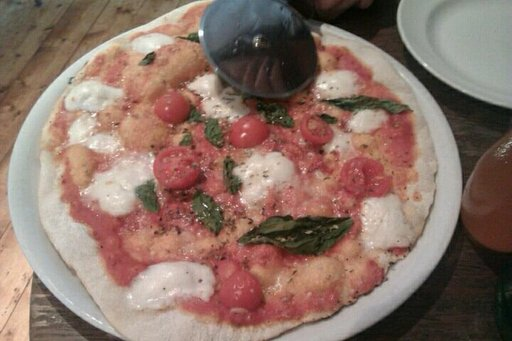

In [ ]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

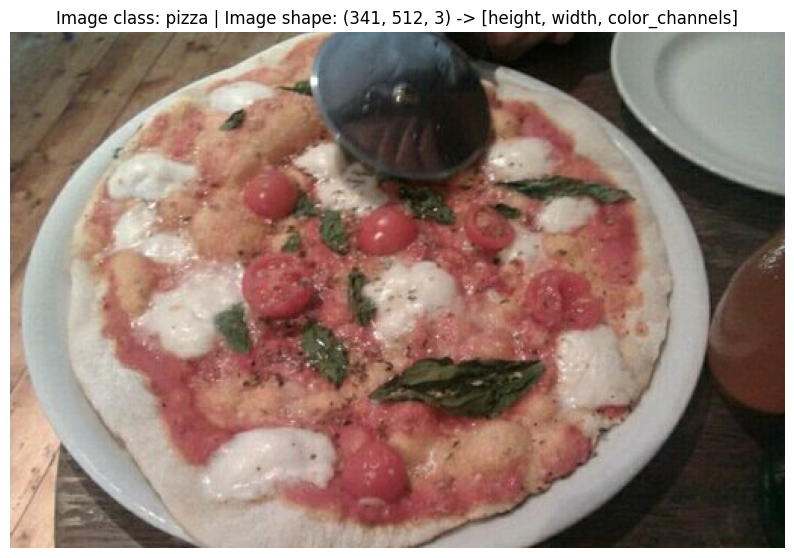

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 Transforming data with `torchvision.transforms`

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
data_transform(img).shape

torch.Size([3, 64, 64])

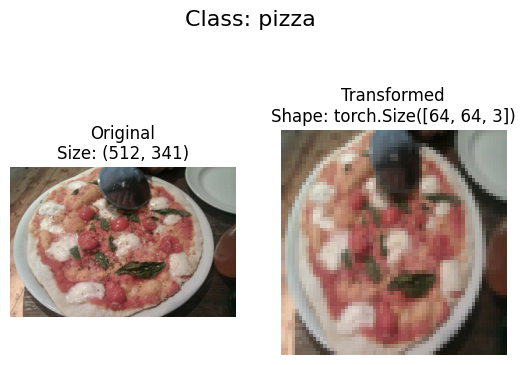

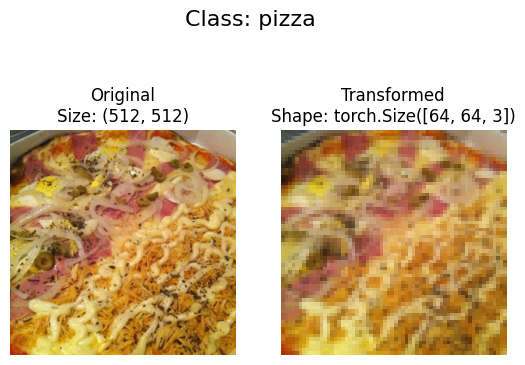

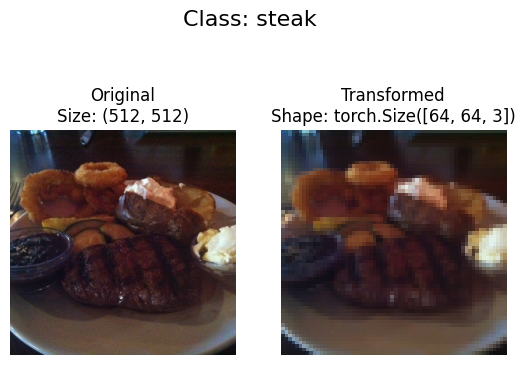

In [ ]:
def plot_transformed_images(image_paths, transforms, n=3, seed = None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transforms(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(
    image_paths = image_path_list,
    transforms = data_transform,
    n = 3,
    seed = 42
)


## 4. Option 1: Loading image data using `ImageFolder`

In [ ]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform = None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label dattype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape:  torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

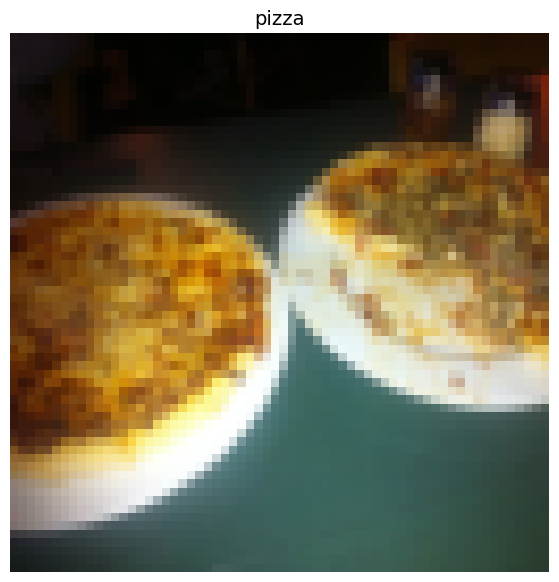

In [ ]:
img_permute = img.permute(1,2,0)

print(f"Original shape:  {img.shape} -> [color_channels, height, width]")
print(f"Image shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn laoded images inot `DataLoader`'s

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = 1,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = 1,
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e29cc727710>,
 <torch.utils.data.dataloader.DataLoader at 0x7e29cc67ca70>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels. height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels. height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading image data with a Custom `Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [ ]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [ ]:
target_directory = train_dir
print(f"Target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir:str, transform = None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(
    targ_dir = train_dir,
    transform = train_transforms
)

test_data_custom = ImageFolderCustom(
    targ_dir = test_dir,
    transform = test_transforms
)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e29cc7015b0>,
 <__main__.ImageFolderCustom at 0x7e29cc700980>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to displayu random images

In [ ]:
def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str] = None,
    n : int = 10,
    display_shape: bool = True,
    seed: int = None
):
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
  if seed:
    random.seed(seed)
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  plt.figure(figsize = (16, 8))

  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]

    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")

    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

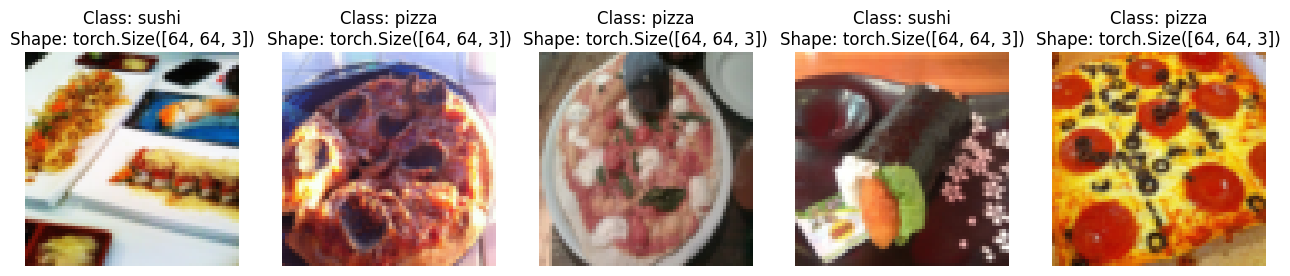

In [ ]:
display_random_images(
    train_data,
    n = 5,
    classes = class_names,
    seed = 42
)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


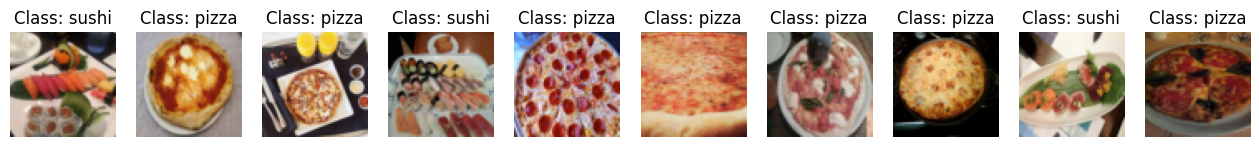

In [ ]:
display_random_images(
    train_data_custom,
    n = 20,
    classes = train_data_custom.classes,
    seed  = 42
)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [ ]:
from pickle import FALSE
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(
    dataset = train_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True
)

test_dataloader_custom = DataLoader(
    dataset = test_data_custom,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)
train_dataloader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x7e29cc37df40>,
 <torch.utils.data.dataloader.DataLoader at 0x7e29fd154500>)

In [ ]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])


In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/1654444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/739735.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1044789.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/786995.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1968947.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1105700.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3441394.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2428085.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2702825.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1033251.jpg')]

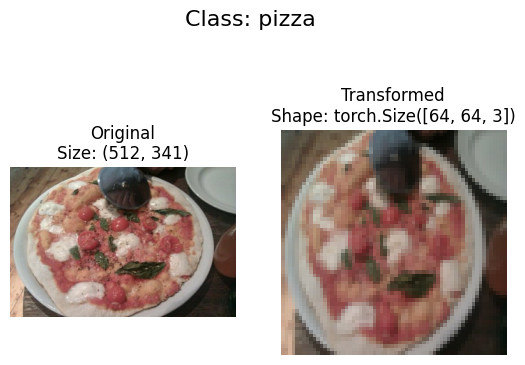

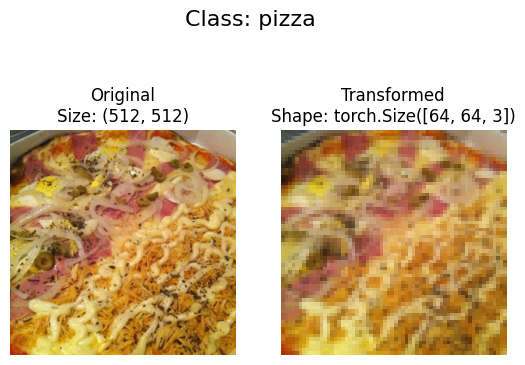

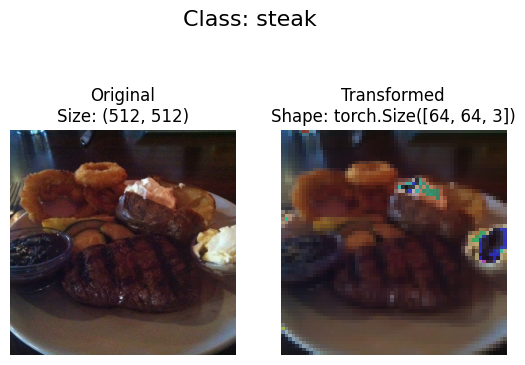

In [ ]:
plot_transformed_images(
    image_paths = image_path_list,
    transforms = train_transform,
    n = 3,
    seed = 42
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform
)

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)


### 7.2 Create TinyVGG model class

In [ ]:
class TinyVGG(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels = input_shape,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size = 2,
            stride = 2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = hidden_units * 169,
            out_features = output_shape
        )
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x


In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(class_names)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
model_0.forward(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device = device
):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device = device
):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim = 1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
    device = device
):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
        model = model,
        dataloader = train_dataloader,
        loss_fn = loss_fn,
        optimizer = optimizer,
        device = device
    )

    test_loss, test_acc = test_step(
        model = model,
        dataloader = test_dataloader,
        loss_fn = loss_fn,
        device = device
    )

    print(f"Epoch: {epoch + 1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  return results

### 7.7 Train and evaluate model 0



In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_0.parameters(),
    lr = 0.001
)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(
    model = model_0,
    train_dataloader = train_dataloader_simple,
    test_dataloader = test_dataloader_simple,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS,
    device = device
)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test_acc: 0.3011
Epoch: 2 | Train loss: 1.0998 | Train acc: 0.3281 | Test loss: 1.0697 | Test_acc: 0.5417
Epoch: 3 | Train loss: 1.0869 | Train acc: 0.4883 | Test loss: 1.0809 | Test_acc: 0.4924
Epoch: 4 | Train loss: 1.0846 | Train acc: 0.4023 | Test loss: 1.0605 | Test_acc: 0.5729
Epoch: 5 | Train loss: 1.0661 | Train acc: 0.4219 | Test loss: 1.0657 | Test_acc: 0.5644
Total training time: 8.780 seconds


In [ ]:
model_0_results

{'train_loss': [1.1063199937343597,
  1.0997995138168335,
  1.0868830680847168,
  1.0845734477043152,
  1.0661440640687943],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.421875],
 'test_loss': [1.0983202854792278,
  1.069681167602539,
  1.0808592240015666,
  1.0605460405349731,
  1.0657143990198772],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5729166666666666,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

In [ ]:
model_0_results.keys()


dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize = (15, 7))
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.legend();

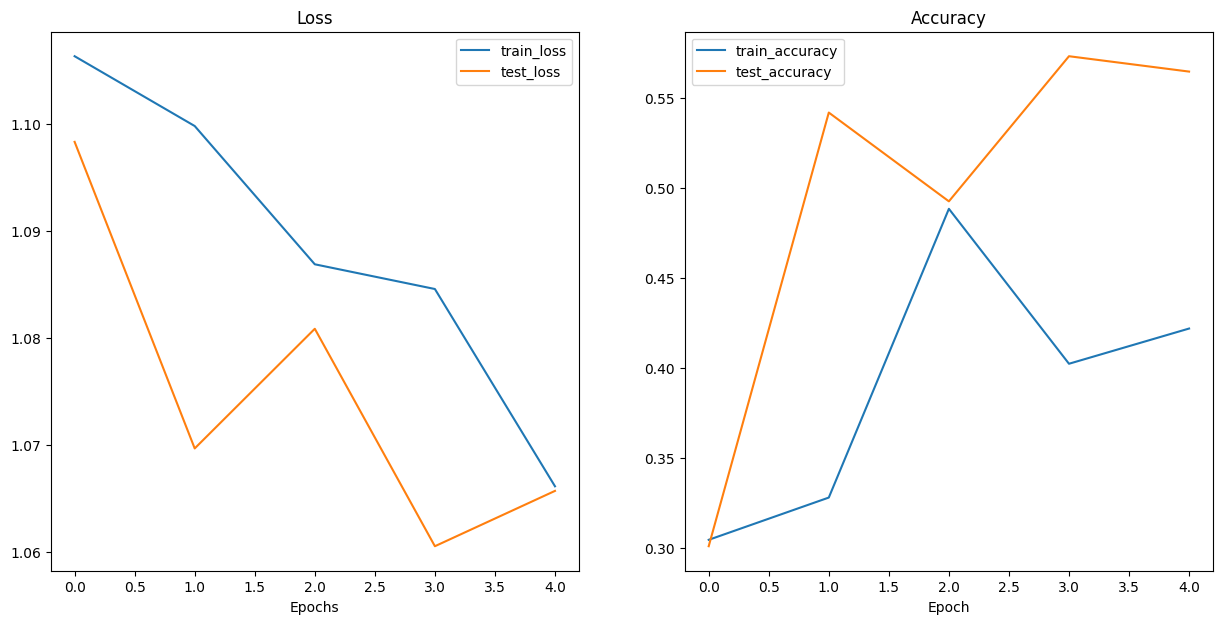

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like

- underfitting
- overfitting

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [ ]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64, 64)),\
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size  =(64, 64)),
    transforms.ToTensor()
])



### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [ ]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform_simple
)

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

from torch.utils.data import DataLoader
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    dataset = train_data_augmented,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)
test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = NUM_WORKERS
)



### 9.3 Construct and train model 1

In [ ]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape = 3,
    hidden_units = 10,
    output_shape = len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params = model_1.parameters(),
    lr = 0.001
)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(
    model = model_1,
    train_dataloader = train_dataloader_augmented,
    test_dataloader = test_dataloader_simple,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS,
    device = device
)

end_time = timer()

print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1049 | Train acc: 0.2500 | Test loss: 1.1019 | Test_acc: 0.2604
Epoch: 2 | Train loss: 1.0807 | Train acc: 0.4258 | Test loss: 1.1261 | Test_acc: 0.2604
Epoch: 3 | Train loss: 1.0712 | Train acc: 0.4258 | Test loss: 1.1593 | Test_acc: 0.2604
Epoch: 4 | Train loss: 1.1254 | Train acc: 0.3047 | Test loss: 1.1581 | Test_acc: 0.2604
Epoch: 5 | Train loss: 1.0858 | Train acc: 0.4258 | Test loss: 1.1551 | Test_acc: 0.3333
Total training time for model_1: 7.569 seconds


### 9.4 Plot the loss curves of model 1

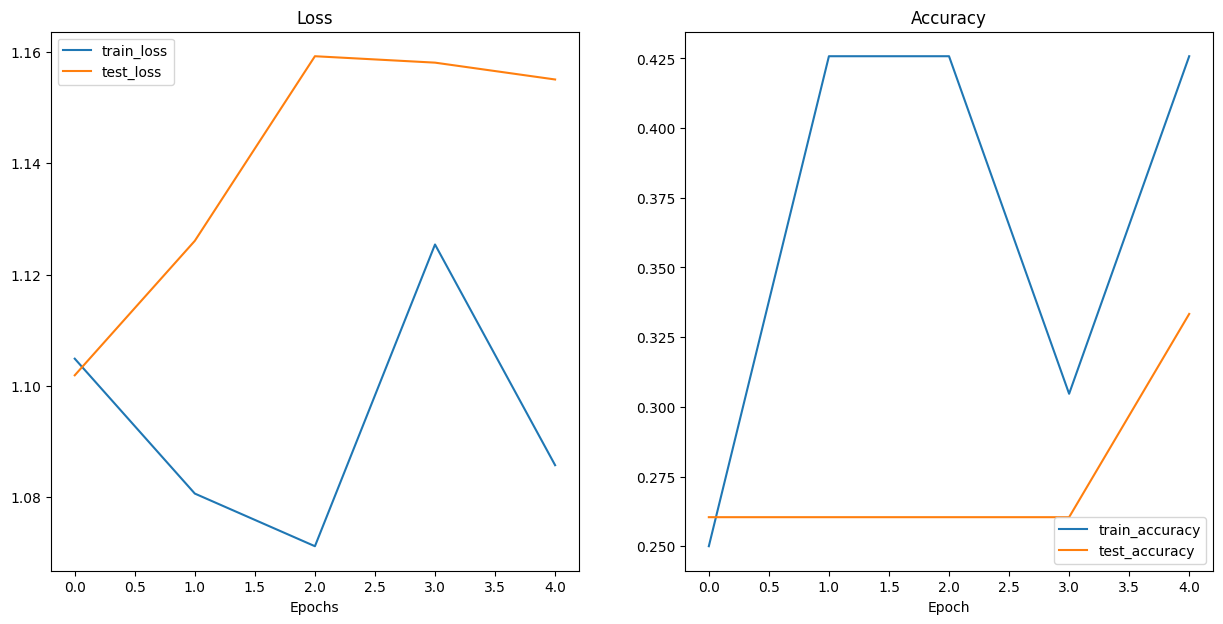

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.106320   0.304688   1.098320  0.301136
 1    1.099800   0.328125   1.069681  0.541667
 2    1.086883   0.488281   1.080859  0.492424
 3    1.084573   0.402344   1.060546  0.572917
 4    1.066144   0.421875   1.065714  0.564394,
    train_loss  train_acc  test_loss  test_acc
 0    1.104914   0.250000   1.101927  0.260417
 1    1.080679   0.425781   1.126088  0.260417
 2    1.071222   0.425781   1.159252  0.260417
 3    1.125429   0.304688   1.158098  0.260417
 4    1.085779   0.425781   1.155072  0.333333)

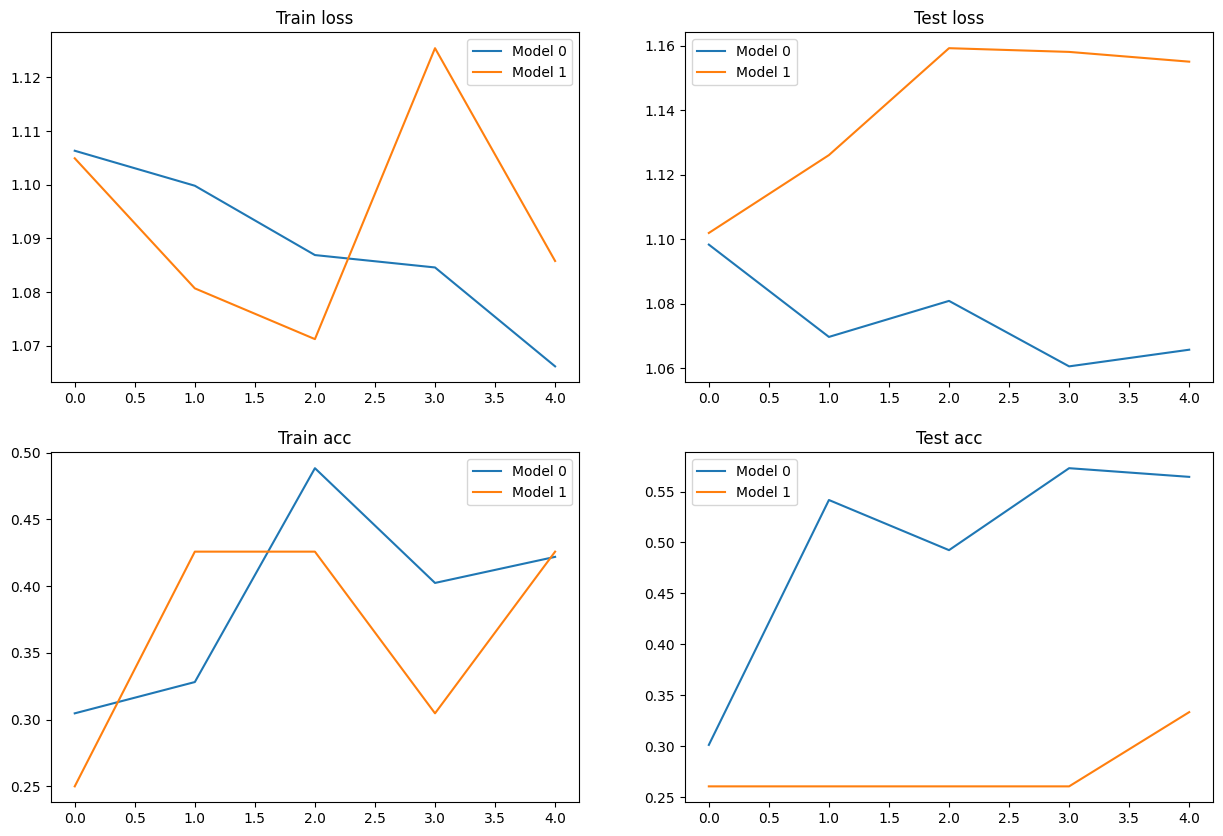

In [ ]:
plt.figure(figsize = (15, 10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train loss")
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test loss")
plt.legend();

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train acc")
plt.legend();

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test acc")
plt.legend();

## 11. Making a prediction on a custom image

In [ ]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping downlaod")

### 11.1 Loading in a custom image with PyTorch

In [ ]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

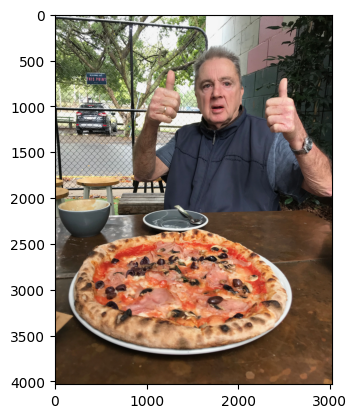

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0));

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) / 255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [ ]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64, 64))
])
custom_image_transformed = custom_image_transform(custom_image)
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


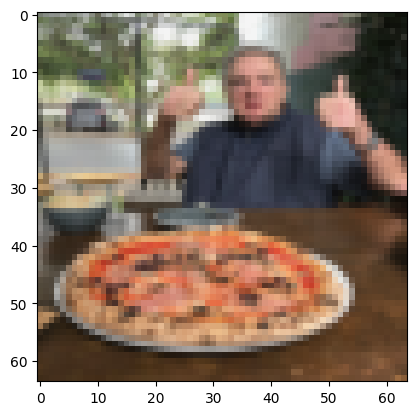

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0796,  0.0360, -0.2084]], device='cuda:0')

In [ ]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.3694, 0.3536, 0.2770]], device='cuda:0')

In [ ]:
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim = 1).cpu()
custom_image_pred_labels

tensor([0])

In [ ]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [ ]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform = None,
    device = device
):
  """
  Makes a prediction on a custom image and plots the image with the prediction
  """
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)
  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0) # this is the batch dimension

    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

  plt.imshow(target_image.squeeze().permute(1,2,0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

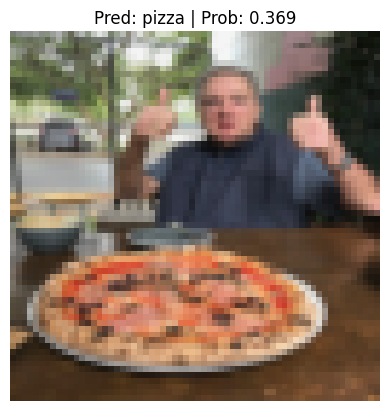

In [ ]:
pred_and_plot_image(
    model = model_1,
    image_path = custom_image_path,
    class_names = class_names,
    transform = custom_image_transform,
    device = device
)